# Overview
This notebook is a project building a sentiment classifier for text of 10,000 movie reviews from IMDb. The dataset is split into 48.22% **positive** and 50.78% **negative** reviews. The smallest and longest reviews are 6- and 9,351-character long, respectively. The project is split in two parts:
- The first part uses a Neural Network built with TensorFlow python library:
    - Comparison between keras Word2Vec and GloVe
    - Use of Dropout and L2 regularization techniques to reduce overfiting
    - Selection of threshold using ROC-AOC
- The second part uses a Naive Bayes approach to create a sentiment classifier model

In [26]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import re
import pickle
from scipy import spatial
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

## 1. TensorFlow Neural Network
For this project, I used a 10,000 movie review database categoriezed into **positive** and **negative** reviews. The data was split into 60-20-20% sets for training, cross validation and testing, respectively. All reviews' text was converted to lowercase letters and had non-alphanumeric characters (e.g., punctuation marks), numbers and on-letter words removed to filter out unimportnat information for the sentiment classification. To speed up the training process, data reviews longer than 200 words (i.e., about 37.1% of the total set) were truncated. The **positive** and **negative** lables were converted to a binary set of 1s and 0s. The reviews were suffled and the ammount of **positive** and **negative** reviews in each of the three sets was cross-checked to avoid skewed datasets. 

In [2]:
def clean_text(text):
    text = text.lower() 
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\b\w\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [3]:
def split_data(X, y, test_size=0.2, val_size=0.2):
    """
    Split data into train, validation, and test sets
    """
    X, y = shuffle(X, y, random_state=42)
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size_adjusted, random_state=42)
    print("Label distribution:")
    print(f"Train set: {np.unique(y_train, return_counts=True)}")
    print(f"Validation set: {np.unique(y_val, return_counts=True)}")
    print(f"Test set: {np.unique(y_test, return_counts=True)}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

### 1.1 Word2Vec
In this section, we compare two methods for text analysis `GloVe` and `Word2Vector`. 

`Word2Vec` creates dense word vectors where semantically similar words are closer together. Words such as "happy" and "joyful" are mapped to vectors that are close to each other in this space, allowing the model to understand relationships between words based on their contexts. `Word2Vec`works by zeroing in on a word and looking at the local contex. It does this by using either Continuous Bag of Words (CBOW) where the model predicts the following word in a sentence base on the previous words. Or Skip-gram where it does the reverse. Starting from a given word predicting the words around it. `Word2Vec` can also understand analogies and perform operations like 'King — Man + Woman = Queen', making it a powerful tool for understanding relationships between words. Because our data set is relatively small, we are going to use Skip-gram.

In [4]:
def train_word2vec(texts, vector_size=100, window=5, min_count=2, workers=4):
    """
    Trains word2vec on tokenized text
    """
    X_train, tokenizer, sequences = tokenize_texts(texts)
    tokenized_texts = [text.split() for text in texts]
    model = Word2Vec(tokenized_texts, vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=1)
    model.save("word2vec_model.model")
    
    return model

In [9]:
def tokenize_texts(texts, max_words=10000, max_len=100):
    texts = [clean_text(text) for text in texts]
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(texts)
    
    vocab_size = len(tokenizer.word_index)
    print(f"Total unique words: {vocab_size:,}")
    print(f"Keeping top {max_words:,} words")
    
    sequences = tokenizer.texts_to_sequences(texts)
    
    seq_lengths = [len(seq) for seq in sequences]
    print("\nSequence length statistics (before padding):")
    print(f"Mean length: {np.mean(seq_lengths):.1f} words")
    print(f"Median length: {np.median(seq_lengths):.1f} words")
    print(f"Max length: {max(seq_lengths):,} words")
    print(f"Min length: {min(seq_lengths):,} words")
    
    n_truncated = sum(len(seq) > max_len for seq in sequences)
    total_samples = len(sequences)
    if n_truncated > 0:
        print(f"\nWARNING: {n_truncated:,} reviews ({(n_truncated/total_samples)*100:.1f}%) "
              f"will be truncated to {max_len} words")
    
    X = pad_sequences(sequences, maxlen=max_len)
    return X, tokenizer, sequences

In [10]:
def test_word2vec_model(model):
    if all(word in model.wv for word in ['woman', 'man', 'king']):
        result = model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)[0]
        print(f"woman + king - man = {result[0]} (similarity: {result[1]:.4f})")
    else:
        print("One or more words not in vocabulary. Try a larger dataset or lower min_count.")
    if all(word in model.wv for word in ['woman', 'man', 'actor']):
        result = model.wv.most_similar(positive=['woman', 'actor'], negative=['man'], topn=1)[0]
        print(f"woman + actor - man = {result[0]} (similarity: {result[1]:.4f})")
    else:
        print("One or more words not in vocabulary. Try a larger dataset or lower min_count.")

In [11]:
def run_pipeline(csv_path):
    df = pd.read_csv(csv_path)
    print(df.columns);
    
    if 'review' not in df.columns or 'sentiment' not in df.columns:
        raise ValueError("CSV file must contain 'review' and 'sentiment' columns.")
    
    X = df['review'].tolist()
    y = df['sentiment'].tolist()


    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, test_size=0.2, val_size=0.2)
    model = train_word2vec(X_train)
    test_word2vec_model(model)

csv_path = '../train_data/reviews.csv'
run_pipeline(csv_path)

Index(['sentiment', 'review'], dtype='object')
Label distribution:
Train set: (array(['Negative', 'Positive'], dtype='<U8'), array([3029, 2971]))
Validation set: (array(['Negative', 'Positive'], dtype='<U8'), array([1028,  972]))
Test set: (array(['Negative', 'Positive'], dtype='<U8'), array([1024,  976]))
Total unique words: 52,579
Keeping top 10,000 words

Sequence length statistics (before padding):
Mean length: 219.2 words
Median length: 162.5 words
Max length: 1,642 words
Min length: 13 words

woman + king - man = sensual (similarity: 0.8382)
woman + actor - man = actress (similarity: 0.7748)


**Remarks**:
- It fails to map 'king' to 'queen' as expected, mapping it to 'Golden' instead. This is because `Word2Vec` understands relationships based on contextual embeddings and the corpus used (i.e., movie reviews). Therefore, the word 'Golden' or 'Britain' is mapped closer to 'king' than 'queen' based on movie titles. To capture the classic, relationship described a different corpus should be used. 
- However, it manages to map actor to actress correctly. This is because the corpus used better captures these semantics.

### 1.2 GloVe
`GloVe` (Global Vector for Word Representation) is somewhat different from `Word2Vec`, but the general idea remains the same: turning words into vectors to capture semantics between them. Instead of looking at the local context around a word, `Glove` constructs a a global co-occurrence matrix. This large matrix of (words x context) co-occurrence information, ie. for each word, expands beyond the local context of a word and looks at its use throughout the entire corpus. Essentially, if two words frequently co-occur (like “doctor” and “hospital”), GloVe will encode that relationship into the vectors. However, training `Glove` from scratch is computationally expensive. Therefore we will use `glove.6B.50d.txt` – 50-dimensional embeddings, trained on 6 billion tokens from Wikipedia.

In [12]:
def load_glove_embeddings(file_path, embedding_dim=100):
    """
    Loads pre-trained GloVe embeddings from a file.
    """
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Loaded {len(embeddings_index)} word vectors.")
    return embeddings_index

In [13]:
def get_word_vector(word, glove_embeddings):
    return glove_embeddings.get(word)

In [29]:
def find_closest_embeddings(embedding, glove_embeddings):
    return sorted(glove_embeddings.keys(), key=lambda word: spatial.distance.euclidean(glove_embeddings[word], embedding))

In [31]:
def vector_analogy(positive_words, negative_words, glove_embeddings):
    positive_vectors = []
    negative_vectors = []
    
    for word in positive_words:
        vector = get_word_vector(word, glove_embeddings)
        if vector is not None:
            positive_vectors.append(vector)
        else:
            print(f"Warning: '{word}' not found in GloVe embeddings.")
    
    for word in negative_words:
        vector = get_word_vector(word, glove_embeddings)
        if vector is not None:
            negative_vectors.append(vector)
        else:
            print(f"Warning: '{word}' not found in GloVe embeddings.")
    
    if not positive_vectors:
        raise ValueError("No valid positive words found in the GloVe embeddings.")
    if not negative_vectors:
        result_vector = sum(positive_vectors)
    else:
        result_vector = sum(positive_vectors) - sum(negative_vectors)
        
    closest_words = find_closest_embeddings(result_vector, glove_embeddings)
    return closest_words

In [39]:
glove_file_path = '../glove.6B/glove.6B.50d.txt'
embedding_dim = 100
glove_embeddings = load_glove_embeddings(glove_file_path, embedding_dim)

positive_words = ['king', 'woman']
negative_words = ['man']

try:
    closest_words = vector_analogy(positive_words, negative_words, glove_embeddings)
    print(f"Analogy result: {positive_words} - {negative_words} -> Closest words: {closest_words[:5]}")
except ValueError as e:
    print(str(e))

positive_words = ['great', 'horrible']
negative_words = ['nice']

try:
    closest_words = vector_analogy(positive_words, negative_words, glove_embeddings)
    print(f"Analogy result: {positive_words} - {negative_words} -> Closest words: {closest_words[:5]}")
except ValueError as e:
    print(str(e))

Loaded 400000 word vectors.
Analogy result: ['king', 'woman'] - ['man'] -> Closest words: ['king', 'queen', 'prince', 'elizabeth', 'daughter']
Analogy result: ['great', 'horrible'] - ['nice'] -> Closest words: ['tragedies', 'tragedy', 'terrible', 'disasters', 'tragic']


**Remarks:**
- `GloVe` embeddings are trained on a large text corpus and capture semantic relationships based on context. `GloVe` understands the relationship between words like "king" and "queen", "woman" and "man", and "great" and "horrible", but some of the results can be influenced by the diversity of contexts it has seen. In this case, we see this for 'tragesdies' and 'disasters', which is probably because the embeddings are trained on a Wikipedia corpus.

### Data Processing Comparison
To determine which approach is beter for our sentiment analysis model, we will use a simple model to train it on both datasets and briefly comapre performance. 

In [16]:
def compare_embeddings(csv_file, glove_path):
    """
    Compare Word2Vec and GloVe embeddings performance.
    """
    # Process with both embeddings
    X_w2v, y_w2v, w2v_matrix, _ = load_and_preprocess_word2vec(csv_file)
    X_glove, y_glove, glove_matrix, _ = load_and_preprocess_glove(csv_file, glove_path)
    
    # Simple LSTM model template
    def create_model(embedding_matrix):
        model = Sequential([
            Embedding(10000, 100, weights=[embedding_matrix], trainable=False),
            LSTM(64),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    # Train and evaluate both models
    print("\nTraining Word2Vec model:")
    w2v_model = create_model(w2v_matrix)
    w2v_history = w2v_model.fit(X_w2v, y_w2v, epochs=3, batch_size=32, validation_split=0.2)
    
    print("\nTraining GloVe model:")
    glove_model = create_model(glove_matrix)
    glove_history = glove_model.fit(X_glove, y_glove, epochs=3, batch_size=32, validation_split=0.2)
    
    # Compare results
    results = {
        'word2vec': {
            'val_accuracy': w2v_history.history['val_accuracy'][-1],
            'train_accuracy': w2v_history.history['accuracy'][-1]
        },
        'glove': {
            'val_accuracy': glove_history.history['val_accuracy'][-1],
            'train_accuracy': glove_history.history['accuracy'][-1]
        }
    }
    
    print("\nFinal Results:")
    print(f"Word2Vec - Train: {results['word2vec']['train_accuracy']:.4f}, "
          f"Val: {results['word2vec']['val_accuracy']:.4f}")
    print(f"GloVe - Train: {results['glove']['train_accuracy']:.4f}, "
          f"Val: {results['glove']['val_accuracy']:.4f}")
    
    return results

CSV_FILE = "../train_data/reviews.csv"
GLOVE_PATH = "glove.6B.100d.txt"

# Run comparison
results = compare_embeddings(CSV_FILE, GLOVE_PATH)

FileNotFoundError: [Errno 2] No such file or directory: 'glove.6B.100d.txt'

### 1.2 Creating the Model
One of the main concerns with creating the neural network model was to avoid overfitting: good performance on the trainning set and poor performance on unseen data. This is the purpose of the cross-validation set, used to decide the training paramaters of the model. Two approaches are explored to counteract overfitting:
- Dropout layer to turn off random neuron units
- L2 regularization to adjust the weights within the neural layers

In [99]:
def create_model_drop(max_words, max_len, embedding_dim=100):
    """
    Create and compile the neural network model
    """
    # Create Adam optimizer with recommended parameters
    adam_optimizer = tf.keras.optimizers.Adam(
        learning_rate=3e-5,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        amsgrad=False,
        clipvalue=1.0
    )

    model = Sequential([
        Embedding(input_dim = max_words, output_dim = embedding_dim, input_length=max_len),
        LSTM(64), 
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=adam_optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model_drop = create_model_drop(MAX_WORDS, MAX_LEN, EMBEDDING_DIM)

In [51]:
def create_model_reg(max_words, max_len, embedding_dim=100):
    """
    Create and compile the neural network model using L1 and L2 regularization
    instead of dropout for controlling overfitting
    """
    # Create Adam optimizer with recommended parameters
    adam_optimizer = tf.keras.optimizers.Adam(
        learning_rate=5e-5,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        amsgrad=False,
        clipvalue=1.0
    )

    # Define regularizers
    l1_l2_reg = tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
    
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len, embeddings_regularizer=l1_l2_reg),
        LSTM(64, kernel_regularizer=l1_l2_reg, recurrent_regularizer=l1_l2_reg),
        Dense(32, activation='relu', kernel_regularizer=l1_l2_reg),
        Dense(1, activation='sigmoid', kernel_regularizer=l1_l2_reg)
    ])
    
    model.compile(
        optimizer=adam_optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model_reg = create_model_reg(MAX_WORDS, MAX_LEN, EMBEDDING_DIM)

### 1.3 Training the Models
We define a function to train and evaluate our model. To further avoid overfitting, we use early stopping when training our model. This approach checks the cross validation loss and stops the training process when this metric stops improving. By doing so, we avoid our model picking up noise from the training set and help it better generalize on unseen data. 

In [52]:
def train_evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test,):
    """
    Train the model and evaluate its performance
    """
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks= early_stopping
    )
    
    # Evaluate on test set
    final_metrics = [model, X_train, y_train, X_val, y_val, X_test, y_test]
    
    return history, final_metrics

In [100]:
# Get timestamp for unique model names
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Train and save dropout model
print("\nTraining dropout model...")
history_drop, final_metrics_drop = train_evaluate_model(
    model_drop, X_train, X_val, X_test, y_train, y_val, y_test
)
model_drop.save(f'../models/model_drop_{timestamp}.h5')


Training dropout model...
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.5061 - loss: 0.6932 - val_accuracy: 0.5350 - val_loss: 0.6927
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.5603 - loss: 0.6920 - val_accuracy: 0.5750 - val_loss: 0.6916
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.6153 - loss: 0.6899 - val_accuracy: 0.6295 - val_loss: 0.6880
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.6795 - loss: 0.6763 - val_accuracy: 0.7560 - val_loss: 0.5977
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.7655 - loss: 0.5738 - val_accuracy: 0.7780 - val_loss: 0.5236
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8128 - loss: 0.4861 - val_accuracy: 0.8155 - val_loss: 0.4646
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.8570 - loss: 0.4128 - val_accuracy: 0.8065 - val_loss: 0.4366
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.89

In [ ]:
# Train and save regularized model
print("\nTraining regularized model...")
history_reg, final_metrics_reg = train_evaluate_model(
    model_reg, X_train, X_val, X_test, y_train, y_val, y_test
)
model_reg.save(f'../models/model_reg_{timestamp}.h5')

### 1.4 Performance Analysis for Dropout Model
In this section we write a function that analyzes the performance of the two neural network models and draws comparisons between them. The aim is to try to identify the most useful techniques for preventing overfitting and improving performance.

In [58]:
def evaluate_final_model(final_metrics):
    """
    Evaluate model on all datasets and return detailed metrics
    
    Parameters:
        model: Keras model
        X_train, X_val, X_test: Input features for each dataset
        y_train, y_val, y_test: Labels for each dataset
    
    Returns:
        Dictionary containing evaluation metrics
    """
    model, X_train, y_train, X_val, y_val, X_test, y_test = final_metrics
    metrics = {}
    
    # Compute predictions for all sets
    y_train_pred_prob = model.predict(X_train, verbose=0)
    y_val_pred_prob = model.predict(X_val, verbose=0)
    y_test_pred_prob = model.predict(X_test, verbose=0)

    # Compute ROC curve for validation set (used to determine the best threshold)
    fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Find the best threshold using Youden’s J statistic
    J_scores = tpr - fpr
    best_index = np.argmax(J_scores)
    best_threshold = thresholds[best_index]

    print(f"\nOptimal Threshold (Youden's J): {best_threshold:.4f}")
    
    # Convert probabilities to binary predictions
    y_train_pred = (y_train_pred_prob > 0.5).astype(int)
    y_val_pred = (y_val_pred_prob > 0.5).astype(int)
    y_test_pred = (y_test_pred_prob > 0.5).astype(int)
    
    # Evaluate metrics for each dataset
    datasets = [
        ('train', X_train, y_train, y_train_pred, y_train_pred_prob),
        ('val', X_val, y_val, y_val_pred, y_val_pred_prob),
        ('test', X_test, y_test, y_test_pred, y_test_pred_prob)
    ]
    
    for name, X, y_true, y_pred, y_pred_prob in datasets:
        # Basic metrics
        loss, accuracy = model.evaluate(X, y_true, verbose=0)
        error = 1 - accuracy
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        # Store metrics
        metrics[f'{name}_error'] = error
        metrics[f'{name}_loss'] = loss
        metrics[f'{name}_accuracy'] = accuracy
        metrics[f'{name}_confusion_matrix'] = cm
        metrics[f'{name}_auc'] = roc_auc
        
        # Print detailed results
        print(f"\n{name.upper()} SET RESULTS:")
        print(f"Error: {error:.4f}")
        print(f"Loss: {loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC-ROC: {roc_auc:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for name, _, y_true, _, y_pred_prob in datasets:
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name.upper()} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()


Optimal Threshold (Youden's J): 0.4960

TRAIN SET RESULTS:
Error: 0.0680
Loss: 0.2487
Accuracy: 0.9320
AUC-ROC: 0.9701
Confusion Matrix:
[[2816  213]
 [ 195 2776]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      3029
           1       0.93      0.93      0.93      2971

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000


VAL SET RESULTS:
Error: 0.1445
Loss: 0.3726
Accuracy: 0.8555
AUC-ROC: 0.9168
Confusion Matrix:
[[879 149]
 [140 832]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1028
           1       0.85      0.86      0.85       972

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000


TEST SET RESU

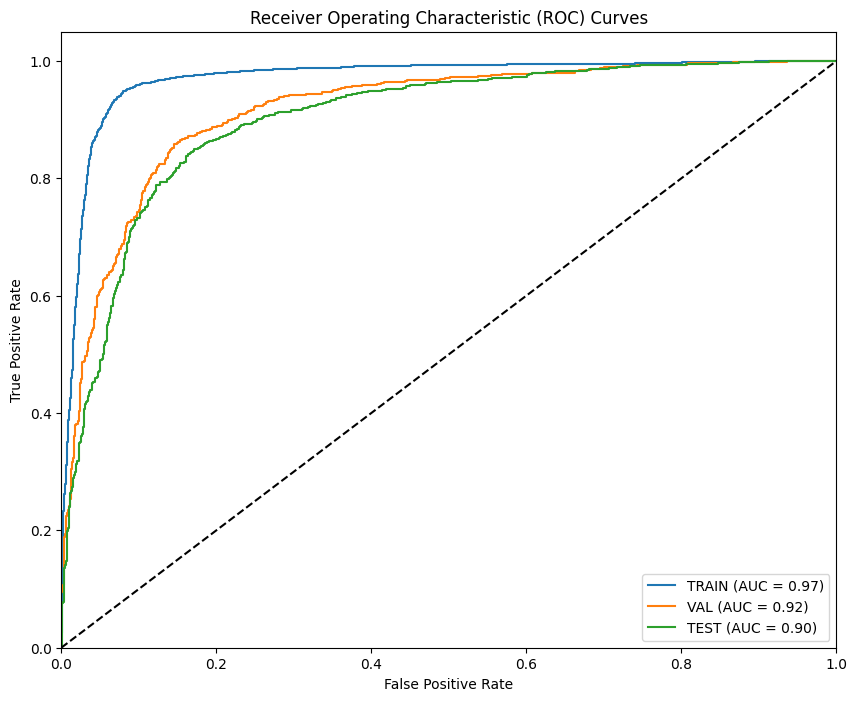

In [61]:
evaluate_final_model(final_metrics_drop)

The peroformance analysis for the dropout model suggests a considerable degree of overfitting. The model performs very well on the training set but shows a drop in accuracy on validation and test sets. Accuracy decreases from 93.2% (train) to 85.6% (val) and 83.6% (test). The model learns patterns in training but struggles with unseen data. AUC-ROC remains good but drops, meaning the model has difficulty separating classes in test data. The confusion matrix shows more false positives and false negatives in test set. 

From the ROC curve, the optimal threshold selected by Youden’s J is 0.4960, meaning that probabilities ≥ 0.4960 are classified as 1. The ROC curve shows the model performs generaly well (much better than a coin-flip), yet a significant difference remains between the test and validation/test curves.

### 1.5 Improvements fro Dropout Model
To improve this, we will investigate the following strategies for our Dropout model:
* Increase dropout rate
* Reduce model complexity

In [97]:
from tensorflow.keras.layers import GRU

def create_model_drop_improv(max_words, max_len, embedding_dim=100):
    """
    Create and compile the neural network model
    """
    # Create Adam optimizer with recommended parameters
    adam_optimizer = tf.keras.optimizers.Adam(
        learning_rate=5e-5,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        amsgrad=False,
        clipvalue=1.0
    )

    model = Sequential([
        Embedding(input_dim = max_words, output_dim = embedding_dim, input_length=max_len),
        LSTM(16),
        Dense(8, activation='relu'),
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=adam_optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model_drop_improv = create_model_drop_improv(MAX_WORDS, MAX_LEN, EMBEDDING_DIM)

/Users/vlad.filip/Desktop/Projects/Sentiment_Analysis_Classifier/myenv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [98]:
# Train and save dropout model
print("\nRe-training dropout model...")
history_drop_improv, final_metrics_drop_improv = train_evaluate_model(
    model_drop_improv, X_train, X_val, X_test, y_train, y_val, y_test
)
model_drop.save(f'../models/model_drop_improv_{timestamp}.h5')


Re-training dropout model...
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4913 - loss: 0.6932 - val_accuracy: 0.5300 - val_loss: 0.6927
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5307 - loss: 0.6922 - val_accuracy: 0.5380 - val_loss: 0.6919
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5664 - loss: 0.6902 - val_accuracy: 0.5460 - val_loss: 0.6905
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5634 - loss: 0.6881 - val_accuracy: 0.5510 - val_loss: 0.6878
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5811 - loss: 0.6828 - val_accuracy: 0.5770 - val_loss: 0.6818
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6035 - loss: 0.6687 - val_accuracy: 0.7175 - val_loss: 0.6584
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6998 - loss: 0.6214 - val_accuracy: 0.7430 - val_loss: 0.5708
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.


Optimal Threshold (Youden's J): 0.5418

TRAIN SET RESULTS:
Error: 0.0705
Loss: 0.4184
Accuracy: 0.9295
AUC-ROC: 0.9726
Confusion Matrix:
[[2805  224]
 [ 199 2772]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3029
           1       0.93      0.93      0.93      2971

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000


VAL SET RESULTS:
Error: 0.1740
Loss: 0.5130
Accuracy: 0.8260
AUC-ROC: 0.9019
Confusion Matrix:
[[814 214]
 [134 838]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1028
           1       0.80      0.86      0.83       972

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000


TEST SET RESU

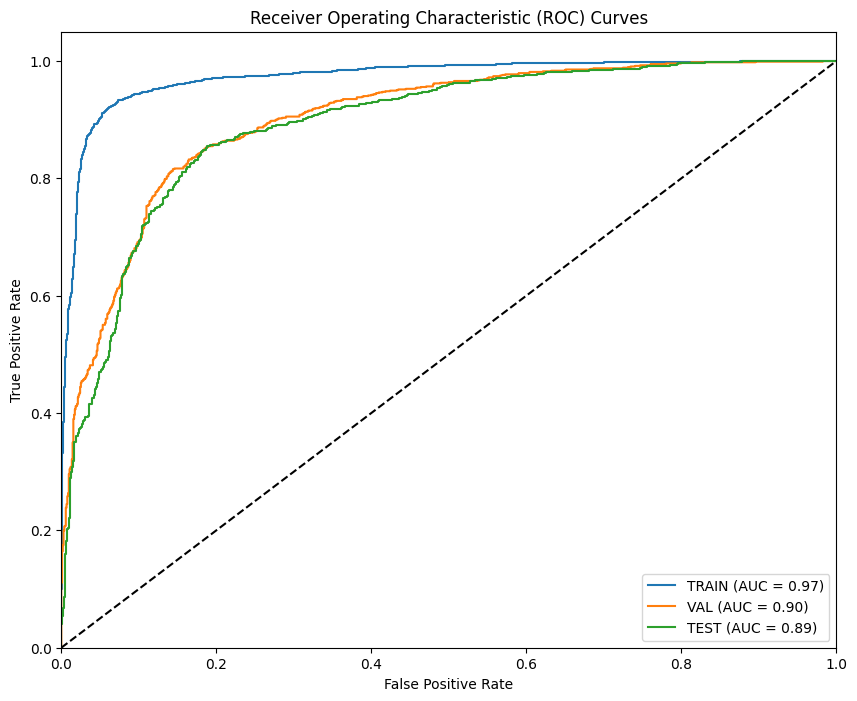

In [101]:
evaluate_final_model(final_metrics_drop_improv)